In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


24946
(100, 100)


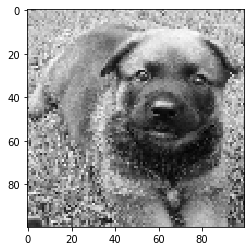

In [3]:
data = np.load('training_data.npy', allow_pickle=True)
print(len(data))
print(data[0][0].shape)
plt.imshow(data[0][0], cmap="gray")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(100,100).view(-1,1,100,100)
        self.flatten_size = None
        x = self.conv(x)
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def conv(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        if self.flatten_size is None:
            self.flatten_size = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
EPOCHS = 5
batch_size = 128  
test_percentage = 0.1

In [5]:
X = torch.Tensor([x[0] for x in data]).to(device)
Y = torch.Tensor([x[1] for x in data]).to(device)
X = X/255.0

test_size = int(len(X) * test_percentage)
X_train = X[:-test_size]
Y_train = Y[:-test_size]
X_test = X[-test_size:]
Y_test = Y[-test_size:]
print(X_train.shape)

torch.Size([22452, 100, 100])


In [6]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc

In [7]:
def train(X, Y, model, EPOCHS, batch_size, criterion, optimizer):
    losses = []
    accuracies = []
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, X.shape[0], batch_size)):
            x , y = X[i:i+batch_size, :].view(-1,1,X.shape[1],X.shape[2]), Y[i:i+batch_size, :]
            model.zero_grad()
            optimizer.zero_grad()
            y_hat = model.forward(x)
            loss = criterion(y_hat,y)
            loss.backward()
            optimizer.step()
            if i%(batch_size*10) == 0:
                losses.append(loss)
        print(np.min(losses))
    return model, accuracies, losses

model, accuracies, losses = train(X_train, Y_train, model, EPOCHS, batch_size, criterion, optimizer)

  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

tensor(0.2191, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

tensor(0.1855, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

tensor(0.1633, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

tensor(0.1440, device='cuda:0', grad_fn=<MseLossBackward>)


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:58<00:00,  3.03it/s]


tensor(0.1230, device='cuda:0', grad_fn=<MseLossBackward>)


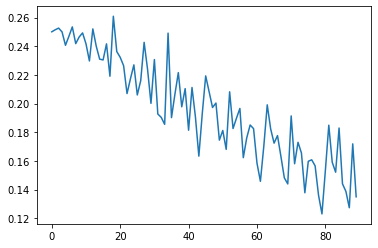

In [10]:
plt.plot(losses)

In [11]:
def accuracy(x, y):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(x))):
            real_class = torch.argmax(y[i])
            net_out = model(x[i].view(-1, 1, 100, 100))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print(correct/total)
accuracy(X_train, Y_train)
accuracy(X_test, Y_test)


  3%|██                                                                             | 67/2494 [00:00<00:07, 325.97it/s]

0.8035809727418493


100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:07<00:00, 334.28it/s]

0.7666399358460305
